In [1]:
import pandas as pd
from pathlib import Path

Plan:

1. visualize how important `[weight_decay, lr, dwell, momentum]` are
2. select some reasonable choices
3. then sweep over `initial_batch_size` and `max_batch_size`

In [9]:
#SWEEPS = Path(".").absolute() / "data-tuning" / "sweep0"
SWEEPS = Path(".").absolute() / "data-tuning" / "sweep"
assert SWEEPS.exists()
dfs = [pd.read_pickle(f) for f in SWEEPS.glob("*.pkl.zip")]
print(len(dfs))
dfs = [df for df in dfs if df.epochs.max() > 10]
print(len(dfs))
df = pd.concat(dfs)
print(len(df), df.columns)
df.head()

576
465
77209 Index(['epoch_time', 'initial_batch_size', 'max_batch_size',
       'batch_growth_rate', 'dampingfactor', 'dampingdelay', 'epochs',
       'verbose', 'lr', 'no_cuda', 'random_state', 'init_seed', 'damper',
       'dataset', 'approx_loss', 'test_freq', 'rho', 'dwell', 'approx_rate',
       'nesterov', 'momentum', 'weight_decay', 'ident', 'tuning',
       'train_x_sum', 'train_y_sum', 'test_x_sum', 'test_y_sum', 'len_train_x',
       'len_train_y', 'len_test_x', 'len_test_y', 'model_updates',
       'num_examples', 'batch_loss', 'num_params', 'len_dataset',
       'device_type', 'loss_name', 'opt_name', 'opt_param_lr',
       'opt_param_momentum', 'opt_param_dampening', 'opt_param_weight_decay',
       'opt_param_nesterov', 'opt_param_maximize', 'opt_param_foreach',
       'opt_param_differentiable', 'opt_param_fused', '_last_batch_losses',
       'approx', 'train_loss', 'train_accuracy', 'train_device',
       'train_prefix', 'test_loss', 'test_accuracy', 'test_device',
  

,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,no_cuda,...,_num_examples,_train_time,_initial,damping,_step_time,time,step_time,lr_,batch_size_,_current
0,1.736589e+09,32,4096,0.01,5,20,0.000000,True,0.003,False,...,5349.0,4.075117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.736589e+09,32,4096,0.01,5,20,1.003000,True,0.003,False,...,5358.0,5.245346,7.218302,17.0,0.007664,1.736589e+09,0.007713,0.003,17.0,13.590669
2,1.736589e+09,32,4096,0.01,5,20,2.007688,True,0.003,False,...,5342.0,4.557442,7.218302,29.0,0.008619,1.736589e+09,0.008671,0.003,29.0,7.981923
3,1.736589e+09,32,4096,0.01,5,20,3.009376,True,0.003,False,...,5350.0,5.002258,7.218302,27.0,0.007793,1.736589e+09,0.007843,0.003,27.0,8.786023
4,1.736589e+09,32,4096,0.01,5,20,4.012563,True,0.003,False,...,5346.0,7.099158,7.218302,23.0,0.007017,1.736589e+09,0.007066,0.003,23.0,10.425639


In [10]:
# plots: show how each parameter sweeps
# assert set(df.lr.unique()) == {1e-3, 3e-3, 10e-3, 30e-3}
# assert set(df.momentum.unique()) == {0.1, 0.3, 0.6, 0.8, 0.9, 0.95}
# assert set(df.dwell.unique().astype(int)) == {1, 3, 10, 30, 100, 300}
# assert set(df.weight_decay.unique()) == {1e-8, 1e-7, 1e-6, 1e-5}

In [11]:
BASE = dict(lr=1e-3, momentum=0.8, dwell=300, weight_decay=1e-5)
# dwell: [300, 3000]
# lr: [1e-5, 3e-3]
# 

27911
1186


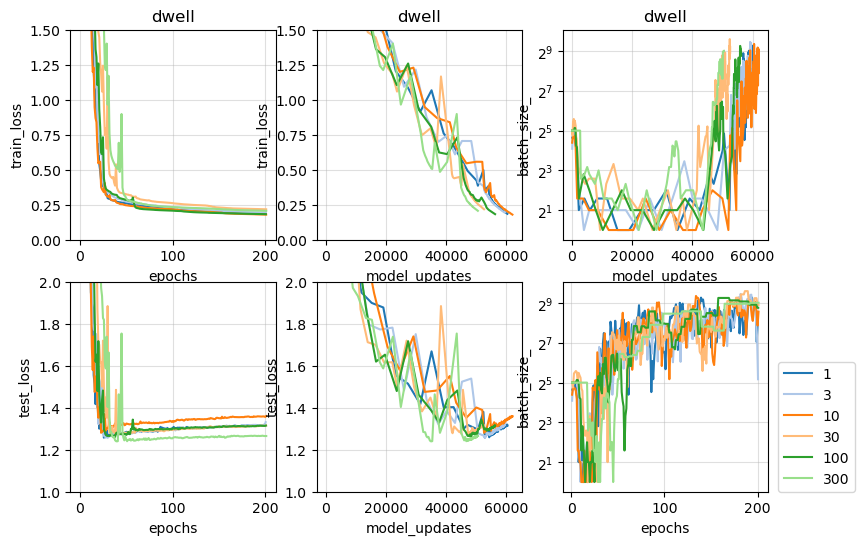

In [12]:
import seaborn as sns
from math import prod
import matplotlib.pyplot as plt
from typing import Dict, Union
# plot lines for dwell

def show_sweep_over(
    sweep: str,
    df: pd.DataFrame,
    base_params: Dict[str, Union[float, int]],
    palette="tab20",
):
    _idx = [df[k] == v for k, v in BASE.items() if k != sweep]
    print(_idx[0].sum())
    idx = prod(_idx).astype(bool)
    print(idx.sum())
    # assert all(idx.sum() > i.sum() for i in _idx)
    show = df[idx].copy().reset_index()
    for k in BASE:
        if k == sweep:
            continue
        assert set(show[k].unique()) == {BASE[k]}
    
    w = 3
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(3 * w, 2 * w))
    kwargs = dict(
        hue=sweep,
        data=show,
        errorbar=None,
        palette=palette,
    )
    sns.lineplot(x="epochs",        y="train_loss", ax=axs[0][0], **kwargs)
    sns.lineplot(x="model_updates", y="train_loss", ax=axs[0][1], **kwargs)
    sns.lineplot(x="model_updates", y="batch_size_", ax=axs[0][2], **kwargs)
    sns.lineplot(x="epochs",        y="test_loss", ax=axs[1][0], **kwargs)
    sns.lineplot(x="model_updates", y="test_loss", ax=axs[1][1], **kwargs)
    sns.lineplot(x="epochs", y="batch_size_", ax=axs[1][2], **kwargs)
    
    
    for i, row in enumerate(axs):
        for k, ax in enumerate(row):
            if i == 0:
                ax.set_title(sweep)
            ax.grid(alpha=0.4)
            if i == 1 and k <= 1:
                ax.set_ylim(1, 2)
            elif i == 0 and k <= 1:
                ax.set_ylim(0, 1.5)
            elif k == 2:
                ax.set_yscale("log", base=2)
    
            if i == 1 and k == 2:
                ax.legend(loc=(1.05, 0))
            else:
                ax.legend_.remove()
    return fig, axs
    

fig, axs = show_sweep_over("dwell", df, BASE, palette="tab20")

12072
740


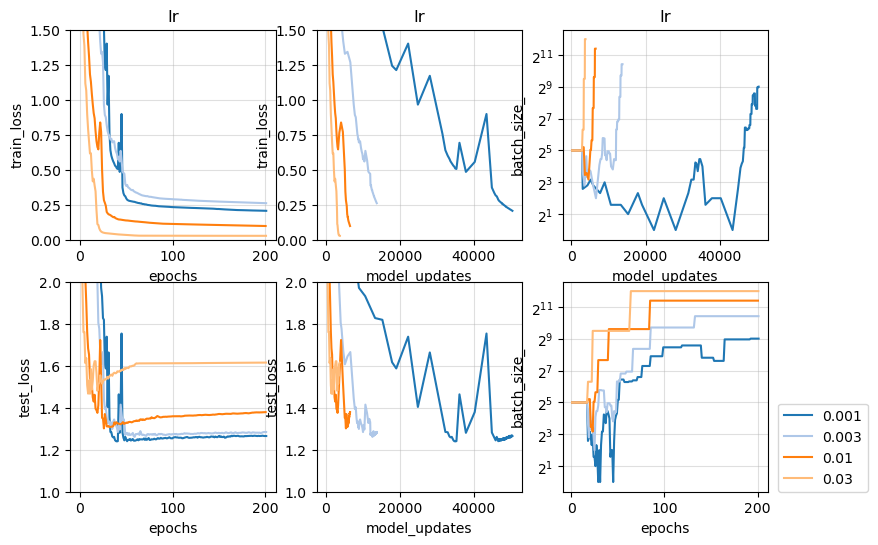

In [13]:
fig, axs = show_sweep_over("lr", df, BASE)

27911
1185


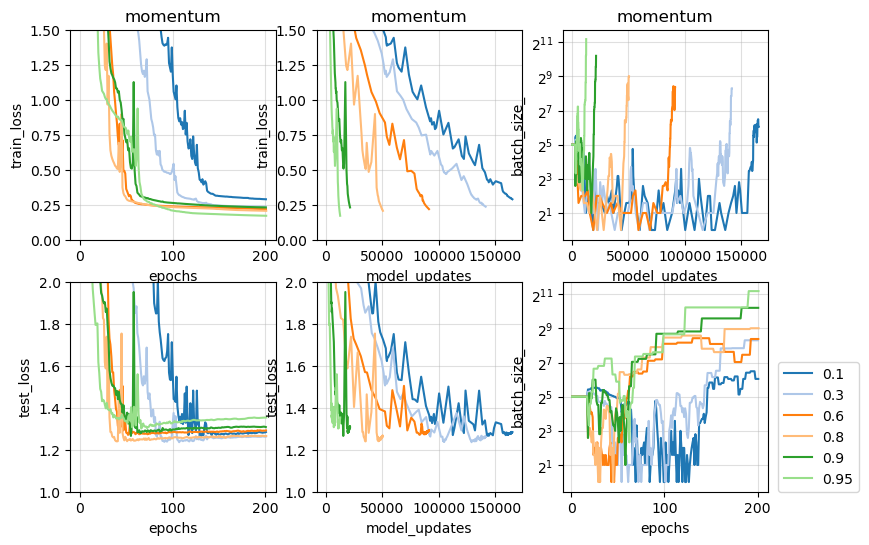

In [14]:
fig, axs = show_sweep_over("momentum", df, BASE)

27911
789


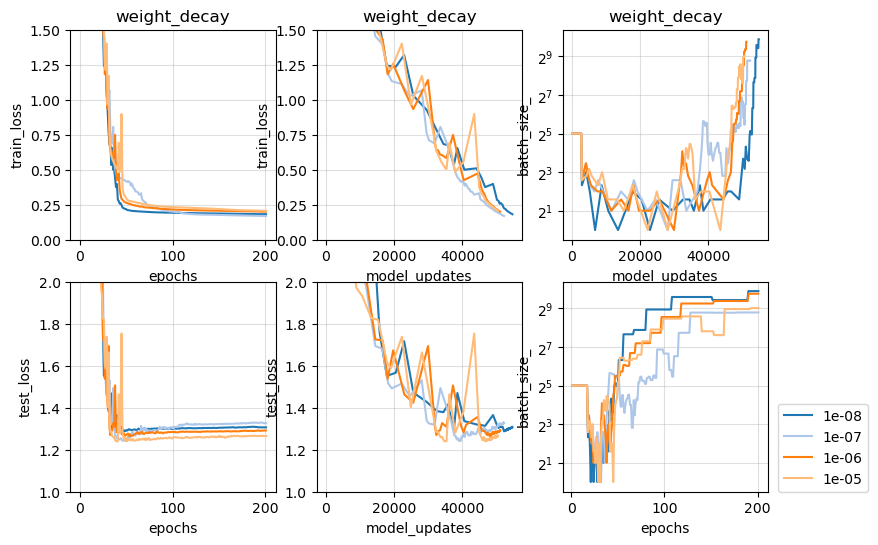

In [15]:
fig, axs = show_sweep_over("weight_decay", df, BASE)